# clean data

## import library

In [2]:
import re
import csv
import numpy as np
import pandas as pd

## column index name

In [3]:
DIC_TITLE_INDEX = {"Admin": 0,"bank" : 0, "trade" : 0, "ceo":0,"community_service" : 0,"construction":0,"design" :0, "edu" : 0,"manufacture": 0, "acct" : 0, "advertising": 0,"call" : 0,  "consult" : 0 }
DIC_LINK_INDEX = {"Admin": 1,"bank" : 1, "trade" : 1, "ceo":1,"community_service" : 1,"construction":1,"design" :1, "edu" : 1,"manufacture": 1, "acct" : 1, "advertising": 1,"call" : 1,  "consult" : 1 }
DIC_COMPANY_INDEX = {"Admin": 2,"bank" : 2, "trade" : 2, "ceo":2,"community_service" : 2,"construction":2,"design" :2, "edu" : 2,"manufacture": 2, "acct" : 2, "advertising": 2,"call" : 2,  "consult" : 2 }
DIC_LOCATION_INDEX = {"Admin": 3,"bank" : 3, "trade" : 3, "ceo":3,"community_service" : 3,"construction":3,"design" :3, "edu" : 3,"manufacture": 3, "acct" : 3, "advertising": 3,"call" : 3,  "consult" : 3 }
DIC_POST_DAY_INDEX ={"Admin": 4,"bank" : 5, "trade" : 5, "ceo":5,"construction":5,"design" :5, "edu" : 5,"manufacture": 5, "acct" : 5, "advertising":6 ,"call" : 5,  "consult" : 5 }
DIC_CLASSI_INDEX ={"Admin": 5,"bank" : 6, "trade" : 6, "ceo":4,"community_service" : 5,"construction":6,"design" :6, "edu" : 4,"manufacture": 4, "acct" : 4, "advertising": 5,"call" : 6,  "consult" : 6 }
DIC_SALARY_INDEX  ={"edu":6,'manufacture':6,"acct" : 6,"advertising": 4,"call" : 6,"consult" : 6 }
LOCATION_INDEX = len('location:')
CLASSIFICATION_INDEX = len('classification:')


## read data

In [4]:
def read_data(file_path,job_name):
    """read csv_file with no header, then call each action of function"""
    csv_new =pd.read_csv(file_path,header= None)
    csv_new = csv_new.drop(csv_new.index[0])
    csv_new = clean_loc_and_area(csv_new,DIC_LOCATION_INDEX[job_name] )
    csv_new =  clean_salary(csv_new,DIC_CLASSI_INDEX[job_name])
    csv_new = clean_classification(csv_new,DIC_CLASSI_INDEX[job_name])
    csv_new = post_and_feature(csv_new, DIC_POST_DAY_INDEX[job_name])
    return csv_new

## clean the location and area column

In [5]:
def clean_loc_and_area(csv_new, index = 3):
    
    '''
    the funcation used to get rid of "location: " value, and also split the location into two piece,
    fill NA in the area and location column.Then, get rid of salary information in the location column,
    for example, #eg. abcabc,$23 per hour.
    Next, get rid of word "area" in the area column, then drop it.
    Finally, call duplicate area function.
    '''
    
    csv_new[index] = csv_new[index].apply(lambda x:x[LOCATION_INDEX:])
    csv_new[['area','location']] = csv_new[index].str.split('area: ', expand = True)
    csv_new['location'].fillna('unknown',inplace = True)
    csv_new['area'].fillna('unknown',inplace = True)
    csv_new['location'] = csv_new['location'].replace('(\,[\s\S]*)',"",regex = True)
    csv_new.drop(columns = [index],inplace = True)
    csv_new['location']= csv_new['location'].apply(dulplicate_loc)
    
    
    csv_new['area'] = csv_new['area'].replace('(area$)',"",regex = True)
    csv_new['area'] = csv_new['area'].apply(dulplicate_area)
    
   
    
    return csv_new

## clean the dulplicate value in the location column

In [6]:
def dulplicate_loc(column):
    '''
    clean the dulplicate value in the location column
    '''
    mid = len(column)//2
    if column == 'unknown':
        return 'unknown'
    else:
        return column[mid:]

## clean the dulplicate value in the area column

In [7]:
def dulplicate_area(column):
    '''
    clean the dulplicate value in the area column
    '''
    mid = len(column)//2
    if column == 'unknown':
        return 'unknown'
    else:
        return column[mid+1:]

## clean the salary column

In [8]:
def clean_salary(csv_new,index):
    '''
    First, find salary information in the classification column by using salary funcation.
    Then, clean the salary column,split salary collumn into two pieces that are called high salary
    and low salary.
    Then extract number that what we want in the low_salary and high_salary column.
    If the low _salary is unknown, high_salary has a number, then put number also in the low_salary column.
    If the high_salary is unknown, low_salary has a number, then put number also in the high_salary column.
    Next, transfer low_salary and high_salary type.
    Count salary for a year in the low salary and high salary column.
    Finally, fill NA in the low salary and high salary column.
    '''
    
    csv_new['salary']= csv_new[index].apply(salary)
    
    csv_new['salary'] = csv_new[csv_new['salary'].str.contains('\d', na= False)]['salary'].str.replace('to','-',regex = True)
    csv_new['salary'] = csv_new[csv_new['salary'].str.contains('\d',na = False)]['salary'].str.replace(',','',regex = True)
    csv_new['salary'] = csv_new[csv_new['salary'].str.contains('\d',na = False)]['salary'].str.replace('\d\%','',regex = True)
 
    csv_new['salary'] = csv_new['salary'].fillna('unknown')
    
    csv_new[['low_salary','high_salary']] = csv_new['salary'].str.split('-',n = 1, expand = True)
    csv_new[['low_salary','high_salary']]=csv_new[['low_salary','high_salary']].fillna('unknown')
    
    csv_new['low_salary'] = csv_new['low_salary'].str.extract(r'(\d+\.\d+|\d+ \d+|\d+k|\d+)',expand = False)
    csv_new['high_salary'] = csv_new['high_salary'].str.extract(r'(\d+\.\d+|\d+ \d+|\d+k|\d+)',expand = False) 
    
    csv_new['low_salary'] = csv_new[csv_new['low_salary'].str.contains('\d',na= False)]['low_salary'].str.replace(' ','',regex = True)
    csv_new['high_salary'] = csv_new[csv_new['high_salary'].str.contains('\d',na= False)]['high_salary'].str.replace(' ','',regex = True)
    
    csv_new['low_salary'] = csv_new[csv_new['low_salary'].str.contains('\d',na = False)]['low_salary'].str.replace('k','000',regex = True)
    csv_new['high_salary'] = csv_new[csv_new['high_salary'].str.contains('\d',na = False)]['high_salary'].str.replace('k','000',regex = True)

    
    csv_new.loc[csv_new['low_salary']=='unknown','low_salary'] = csv_new['high_salary']
    csv_new.loc[csv_new['high_salary']=='unknown','high_salary'] = csv_new['low_salary']
    
    csv_new['low_salary'] = csv_new['low_salary'].astype('float32')
    csv_new['high_salary'] = csv_new['high_salary'].astype('float32')
    
    csv_new.loc[csv_new['low_salary'] < 50, 'low_salary'] = csv_new['low_salary'] * 8*200
    csv_new.loc[csv_new['high_salary'] < 50, 'high_salary'] = csv_new['high_salary'] * 8*200
    
    csv_new['low_salary']=csv_new['low_salary'].fillna('unknown')
    csv_new['high_salary']=csv_new['high_salary'].fillna('unknown')
    
    
    
    return csv_new

## find salary value in the classification column

In [9]:
def salary(column):
    '''
    find salary value in the classification column
    '''
    if "classification" in column:
        return 'unknown'
    else:
        return column

## clean the classification column

In [10]:
def clean_classification(csv_new, index):
    '''
    The function is used to clean the classification column.
    Firstly, we use the classi funcation, to get rid of the column has salary information.
    Then, we fill NA value to unknown in the classification column. 
    Next, we split the collumn by 'subclassification: ' into two pieces that are 'classification_change'
    and 'classification'column.
    We call the duplicate_classi funcation to clean the dulplicate value in the classification column
    Then, get rid of 'classificaiton:' in the classification column.And split the classification_change into 3pieces.
    Drop the original one.
    In addition, fill NA value in the classification1, classification2, classification3 and company column
    Finally, call the random1 funcation to estimate salary in the high_salary and low_salary column.
    
    '''
    
    
    csv_new['classification']=csv_new[index].apply(classifi)
    
    csv_new['classification'] = csv_new['classification'].fillna('unknown')
    
    csv_new[['classification_change','classification']] = csv_new['classification'].str.split('subClassification: ',expand =True)
    
    csv_new['classification']=csv_new['classification'].fillna('unknown')
    csv_new['classification'] = csv_new['classification'].apply(dulplicate_classi)
    csv_new['classification_change'] = csv_new['classification_change'].apply(lambda x:x[CLASSIFICATION_INDEX:])
    csv_new[['classification1','classification2','classification3']] = csv_new['classification_change'].str.split(' & ',expand = True)
    csv_new.drop(columns = ['classification_change',index], inplace = True)
    
    csv_new['classification1']= csv_new['classification1'].fillna('unknown')
    csv_new['classification1'] = csv_new['classification1'].apply(classification)
    csv_new['classification2']= csv_new['classification2'].fillna('unknown')
    csv_new['classification2'] = csv_new['classification2'].apply(classification)
    csv_new['classification3']= csv_new['classification3'].fillna('unknown')
    csv_new['classification3'] = csv_new['classification3'].apply(classification)
    
    csv_new['high_salary']= random1(csv_new['high_salary'])
    csv_new['low_salary'] = random1(csv_new['low_salary'])
    
    
    csv_new['company'] = csv_new[2].fillna('unknown')
    
    
    
    return csv_new
    
    

In [11]:
def classification(a):
    '''
    Get rid of '' in the classification1, classification2, classification3 column.
    '''
    if a == '':
        return 'unknown'
    else:
        return a 

## estimate salary for unknown value in the low and high salary column.

In [12]:
def random1(column):
    '''
    Random select number from $45000 and $75000.
    Search on the website the salary range for the most of the job is between $45000 and $75000
    
    '''
    np.random.randint(45000,75000,size = 1)
    for index1, row in enumerate(column.values):
        if row == "unknown":
            column[index1] = np.random.randint(45000, 75000,size = 1 )[0]
    return column
   
            

In [13]:
# clean out $23- $25 per hour
def classifi(a):
    '''
    clean salary information in the classification column.
    '''
    if "classification" not in a :
        return None
    else:
        return a 

## clean the dulplicate value in the classification collumn

In [14]:
def dulplicate_classi(a):
    '''
    clean the dulplicate value in the classification column
    '''
    mid = len(a)//2
    if a == 'unknown':
        return 'unknown'
    else:
        return a[mid:]

## clean the post_time and feature column

In [15]:

def post_and_feature(csv_new, index):
    
    '''
    split the post time column into two pieces that are 'post_time' and 'feature_at' column.
    fill NA value in the post_time and feature_at column
    extract day post time in the post_time column,for example, 21d ago change to 21d
    transfer the post_time to string.
    Finally ,use the post_time funcation to extract number in the post_time column,
    and drop the original column
    '''
    csv_new[['post_time','feature_at']] = csv_new[index].str.split(',at,', expand = True)
    
    csv_new['post_time']= csv_new['post_time'].fillna('unknown')
    csv_new['feature_at'] = csv_new['feature_at'].fillna('unknown')
    
    csv_new['post_time']= csv_new['post_time'].str.extract('(\d+[a-z]+)',expand = False)
    
    csv_new['post_time'] = csv_new['post_time'].astype('str')
    csv_new['post_time'] = csv_new['post_time'].apply(post_time)
    
    csv_new.drop(columns = [index],inplace = True)
    return csv_new


## extract number in the post_time column

In [16]:
def post_time(a):
    '''
    extract time number posted based on day.
    '''
    if 'd' in a:
        find1 = int(a.index('d'))
        return -int(a[:find1])
    elif "m" in a:
        find2 = a.index('m')
        final = -int(a[:find2]) *30
        return final 
    else:
        return 0


In [17]:
admin_df = read_data('/Users/wangzhuoxin/Desktop/project_resource/NZ_Admin_JOBS.csv',"Admin")
admin_df 

,0,1,2,area,location,salary,low_salary,high_salary,classification,classification1,classification2,classification3,company,post_time,feature_at
1,Administrator,https://www.seek.co.nz/job/50582301?type=promo...,NaN,Bay of Plenty,Tauranga,unknown,66235,60323,Office Management,Administration,Office SupportAdministration,Office Support,unknown,0,Private Advertiser
2,Receptionist,https://www.seek.co.nz/job/50620889?type=promo...,Avenues Orthodontics,Bay of Plenty,Tauranga,unknown,47501,56028,Receptionists,Administration,Office SupportAdministration,Office Support,Avenues Orthodontics,0,unknown
3,Prosecutions Support Officer,https://www.seek.co.nz/job/50622169?type=stand...,New Zealand Police,Auckland,unknown,unknown,71704,55507,Other,Administration,Office SupportAdministration,Office Support,New Zealand Police,-4,unknown
4,Early Childhood Centre Administrator,https://www.seek.co.nz/job/50639620?type=stand...,Kew Pacific Island Early Learning Centre,Southland,Invercargill,unknown,58905,58475,Administrative Assistants,Administration,Office SupportAdministration,Office Support,Kew Pacific Island Early Learning Centre,0,unknown
5,Business Support Administrator,https://www.seek.co.nz/job/50622432?type=stand...,NaN,Canterbury,Christchurch,unknown,51313,52608,Client & Sales Administration,Administration,Office SupportAdministration,Office Support,unknown,-4,Private Advertiser
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2704,Key Account Manager,https://www.seek.co.nz/job/50490062?type=stand...,Hays Talent Solutions,Auckland,Auckland Central,unknown,70445,46685,Client & Sales Administration,Administration,Office SupportAdministration,Office Support,Hays Talent Solutions,-27,unknown
2705,Executive Assistant,https://www.seek.co.nz/job/50488000?type=stand...,one eighty recruitment,Wellington,Wellington Central,unknown,57597,73153,unknown,unknown,unknown,unknown,one eighty recruitment,-27,unknown
2706,Temporary Office Roles,https://www.seek.co.nz/job/50524865?type=stand...,Asset Recruitment Ltd,Waikato,Hamilton,unknown,65287,67534,unknown,unknown,unknown,unknown,Asset Recruitment Ltd,-20,unknown
2707,Temporary Office Roles,https://www.seek.co.nz/job/50477118?type=stand...,Asset Recruitment Ltd,Waikato,Hamilton,unknown,62859,62593,unknown,unknown,unknown,unknown,Asset Recruitment Ltd,-28,unknown


In [18]:
trade_df = read_data('/Users/wangzhuoxin/Desktop/project_resource/NZ_TRADE_SERVICES_JOBS.csv',"trade")
trade_df.head()

,0,1,2,4,area,location,salary,low_salary,high_salary,classification,classification1,classification2,classification3,company,post_time,feature_at
1,Cabinet Maker - Kitchens,https://www.seek.co.nz/job/50581799?type=promo...,Kitchen Link (2015) Ltd,classification: Trades & ServicesTrades & Serv...,Auckland,Rodney & North Shore,unknown,unknown,unknown,Carpentry & Cabinet Making,Trades,ServicesTrades,Services,Kitchen Link (2015) Ltd,0,unknown
2,Retaining Wall Skilled Operator/Builder,https://www.seek.co.nz/job/50610755?type=promo...,Hamilton Fencing Ltd,classification: Trades & ServicesTrades & Serv...,Waikato,Hamilton,$27.50 - $40.00 per hourPlus Time and a half,53199,60645,unknown,unknown,unknown,unknown,Hamilton Fencing Ltd,0,unknown
3,Trainee Locksmith,https://www.seek.co.nz/job/50590717?type=stand...,EQUIP Recruitment Ltd,classification: Trades & ServicesTrades & Serv...,Wellington,Hutt Valley,unknown,72952,59620,Locksmiths,Trades,ServicesTrades,Services,EQUIP Recruitment Ltd,-5,unknown
4,Labourer,https://www.seek.co.nz/job/50606442?type=stand...,AB Contracting Ltd,classification: Trades & ServicesTrades & Serv...,Canterbury,Christchurch,unknown,52120,57978,Labourers,Trades,ServicesTrades,Services,AB Contracting Ltd,-1,unknown
5,Sawmill Labourers,https://www.seek.co.nz/job/50608729?type=stand...,Superior Personnel Ltd,classification: Trades & ServicesTrades & Serv...,Canterbury,North Canterbury,unknown,unknown,unknown,Labourers,Trades,ServicesTrades,Services,Superior Personnel Ltd,0,unknown


In [19]:
bank_df = read_data('/Users/wangzhuoxin/Desktop/project_resource/NZ_Banking_JOBS.csv',"bank")
bank_df.head()

,0,1,2,4,area,location,salary,low_salary,high_salary,classification,classification1,classification2,classification3,company,post_time,feature_at
1,Accounts Receivable,https://www.seek.co.nz/job/50568753?type=promo...,at MTF Finance Mt Wellington,classification: Banking & Financial ServicesBa...,Auckland,Auckland Central,unknown,50203,61577,Credit,Banking,Financial ServicesBanking,Financial Services,at MTF Finance Mt Wellington,0,unknown
2,Internal Audit Manager,https://www.seek.co.nz/job/50556333?type=promo...,at Industrial and Commercial Bank of China (Ne...,classification: Banking & Financial ServicesBa...,Auckland,Auckland Central,unknown,52373,54367,Compliance & Risk,Banking,Financial ServicesBanking,Financial Services,at Industrial and Commercial Bank of China (Ne...,0,unknown
3,Client Services Officer,https://www.seek.co.nz/job/50638706?type=stand...,at NZ Funds Management Limited,classification: Banking & Financial ServicesBa...,Auckland,Auckland Central,unknown,55281,56941,Client Services,Banking,Financial ServicesBanking,Financial Services,at NZ Funds Management Limited,0,unknown
4,Customer Banking Consultant - Invercargill,https://www.seek.co.nz/job/50637958?type=stand...,at Westpac,classification: Banking & Financial ServicesBa...,Southland,Invercargill,unknown,53538,62427,unknown,unknown,unknown,unknown,at Westpac,-1,unknown
5,Private Wealth Assistant - Queenstown,https://www.seek.co.nz/job/50617226?type=stand...,at Craigs Investment Partners,classification: Banking & Financial ServicesBa...,Otago,Queenstown & Wanaka,unknown,55260,45046,Client Services,Banking,Financial ServicesBanking,Financial Services,at Craigs Investment Partners,-5,unknown


In [20]:
"""
admin_df['count'] = 1
admin_loc_df = admin_df[['area','count']].groupby(admin_df['area']).sum().reset_index()
admin_loc_df.drop(index = [0,1,2,3,19,20],inplace = True)
admin_loc_df.reset_index(drop = True)
#print(admin_loc_df)
trade_df['count'] = 1
trade_loc_df = trade_df[['area','count']].groupby(trade_df['area']).sum().reset_index()

trade_loc_df.drop(index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,36,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56],inplace = True)
trade_loc_df.reset_index(drop = True)
#print(trade_loc_df)

bank_df['count'] = 1
bank_loc_df = bank_df[['area','count']].groupby(bank_df['area']).sum().reset_index()

bank_loc_df.drop(index = [0,16,17],inplace = True)
bank_loc_df.reset_index(drop = True)
#print(bank_loc_df)

final_df = pd.concat([admin_loc_df, trade_loc_df,bank_loc_df] , join="outer",ignore_index=True)

final_df
#
"""

'\nadmin_df[\'count\'] = 1\nadmin_loc_df = admin_df[[\'area\',\'count\']].groupby(admin_df[\'area\']).sum().reset_index()\nadmin_loc_df.drop(index = [0,1,2,3,19,20],inplace = True)\nadmin_loc_df.reset_index(drop = True)\n#print(admin_loc_df)\ntrade_df[\'count\'] = 1\ntrade_loc_df = trade_df[[\'area\',\'count\']].groupby(trade_df[\'area\']).sum().reset_index()\n\ntrade_loc_df.drop(index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,36,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56],inplace = True)\ntrade_loc_df.reset_index(drop = True)\n#print(trade_loc_df)\n\nbank_df[\'count\'] = 1\nbank_loc_df = bank_df[[\'area\',\'count\']].groupby(bank_df[\'area\']).sum().reset_index()\n\nbank_loc_df.drop(index = [0,16,17],inplace = True)\nbank_loc_df.reset_index(drop = True)\n#print(bank_loc_df)\n\nfinal_df = pd.concat([admin_loc_df, trade_loc_df,bank_loc_df] , join="outer",ignore_index=True)\n\nfinal_df\n#\n'

In [23]:
"""
# do the region_sum2 df used for the GIS_Plot.ipynb
# concact the three different df, then count the total job in different area.
#Finally, put the df transfer to csv file

result_df = pd.concat([admin_df, trade_df,bank_df] , join="outer",sort = False)
#result_df
result_df['count'] = 1
result_df = result_df[['area','count']].groupby(result_df['area']).sum().reset_index()

result_df.drop(index = [i for i in range(35)],inplace = True)
result_df.drop(index = [i for i in range(53,69)],inplace = True)
result_df.drop(index = [37,45,49],inplace = True)
result_df.columns = ['REGC2016_N','JOB_COUNT']
result_df = result_df.reset_index()

result_df.drop(columns = ['index'],inplace = True)
result_df['REGC2016_N'] = [str(col) + ' Region' for col in result_df['REGC2016_N']]

result_df['REGC2016_N'] = result_df['REGC2016_N'].replace(['Hawkes Bay Region'],"Hawke's Bay Region")
result_df['REGC2016_N'] = result_df['REGC2016_N'].replace(['Manawatu Region'],"Manawatu-Wanganui Region")

result_df.to_csv('/Users/wangzhuoxin/Desktop/region_sum2.csv',index = False)
"""




'\n# do the region_sum2 df used for the GIS_Plot.ipynb\n# concact the three different df, then count the total job in different area.\n#Finally, put the df transfer to csv file\n\nresult_df = pd.concat([admin_df, trade_df,bank_df] , join="outer",sort = False)\n#result_df\nresult_df[\'count\'] = 1\nresult_df = result_df[[\'area\',\'count\']].groupby(result_df[\'area\']).sum().reset_index()\n\nresult_df.drop(index = [i for i in range(35)],inplace = True)\nresult_df.drop(index = [i for i in range(53,69)],inplace = True)\nresult_df.drop(index = [37,45,49],inplace = True)\nresult_df.columns = [\'REGC2016_N\',\'JOB_COUNT\']\nresult_df = result_df.reset_index()\n\nresult_df.drop(columns = [\'index\'],inplace = True)\nresult_df[\'REGC2016_N\'] = [str(col) + \' Region\' for col in result_df[\'REGC2016_N\']]\n\nresult_df[\'REGC2016_N\'] = result_df[\'REGC2016_N\'].replace([\'Hawkes Bay Region\'],"Hawke\'s Bay Region")\nresult_df[\'REGC2016_N\'] = result_df[\'REGC2016_N\'].replace([\'Manawatu Reg

# machine learning part 


In [112]:
# concat three different field into one dataframe, named result_df
result_df = pd.concat([admin_df, trade_df,bank_df] , axis=0,sort = False)
result_df

,0,1,2,area,location,salary,low_salary,high_salary,classification,classification1,classification2,classification3,company,post_time,feature_at,4
1,Administrator,https://www.seek.co.nz/job/50582301?type=promo...,NaN,Bay of Plenty,Tauranga,unknown,66235,60323,Office Management,Administration,Office SupportAdministration,Office Support,unknown,0,Private Advertiser,NaN
2,Receptionist,https://www.seek.co.nz/job/50620889?type=promo...,Avenues Orthodontics,Bay of Plenty,Tauranga,unknown,47501,56028,Receptionists,Administration,Office SupportAdministration,Office Support,Avenues Orthodontics,0,unknown,NaN
3,Prosecutions Support Officer,https://www.seek.co.nz/job/50622169?type=stand...,New Zealand Police,Auckland,unknown,unknown,71704,55507,Other,Administration,Office SupportAdministration,Office Support,New Zealand Police,-4,unknown,NaN
4,Early Childhood Centre Administrator,https://www.seek.co.nz/job/50639620?type=stand...,Kew Pacific Island Early Learning Centre,Southland,Invercargill,unknown,58905,58475,Administrative Assistants,Administration,Office SupportAdministration,Office Support,Kew Pacific Island Early Learning Centre,0,unknown,NaN
5,Business Support Administrator,https://www.seek.co.nz/job/50622432?type=stand...,NaN,Canterbury,Christchurch,unknown,51313,52608,Client & Sales Administration,Administration,Office SupportAdministration,Office Support,unknown,-4,Private Advertiser,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3880,Financial Advisor,https://www.seek.co.nz/job/50497173?type=stand...,at NetYourJob,Auckland,Rodney & North Shore,unknown,62725,62868,unknown,unknown,unknown,unknown,at NetYourJob,-26,unknown,classification: Banking & Financial ServicesBa...
3881,Senior Private Wealth Specialist,https://www.seek.co.nz/job/50526368?type=stand...,at Debbie Graham & Associates Limited,Auckland,unknown,unknown,71550,68861,Financial Planning,Banking,Financial ServicesBanking,Financial Services,at Debbie Graham & Associates Limited,-20,unknown,classification: Banking & Financial ServicesBa...
3882,Financial Adviser (Auckland),https://www.seek.co.nz/job/50501103?type=stand...,at Tyler Wren,Auckland,Auckland Central,unknown,58305,73801,unknown,unknown,unknown,unknown,at Tyler Wren,-25,unknown,classification: Banking & Financial ServicesBa...
3883,New Ventures Manager,https://www.seek.co.nz/job/50487878?type=stand...,at Matthew Wood Search,Auckland,Auckland Central,unknown,52579,71142,Corporate Finance & Investment Banking,Banking,Financial ServicesBanking,Financial Services,at Matthew Wood Search,-27,unknown,classification: Banking & Financial ServicesBa...


In [113]:
"""
we want to create a machine learning model by using job title, company name, 
location and post time these features to predict the trend of high salary.
"""
# independent variable that input feature
x_df = result_df[[0, 2,'location','post_time']]

# predict high salary
y_df =result_df['high_salary']

In [114]:
x_df.columns =['job_role', 'company_name', 'location', 'post_time']

In [115]:
x_df

,job_role,company_name,location,post_time
1,Administrator,NaN,Tauranga,0
2,Receptionist,Avenues Orthodontics,Tauranga,0
3,Prosecutions Support Officer,New Zealand Police,unknown,-4
4,Early Childhood Centre Administrator,Kew Pacific Island Early Learning Centre,Invercargill,0
5,Business Support Administrator,NaN,Christchurch,-4
...,...,...,...,...
3880,Financial Advisor,at NetYourJob,Rodney & North Shore,-26
3881,Senior Private Wealth Specialist,at Debbie Graham & Associates Limited,unknown,-20
3882,Financial Adviser (Auckland),at Tyler Wren,Auckland Central,-25
3883,New Ventures Manager,at Matthew Wood Search,Auckland Central,-27


In [116]:
y_df

1         60323
2         56028
3         55507
4         58475
5         52608
         ...   
3880      62868
3881      68861
3882      73801
3883      71142
3884    unknown
Name: high_salary, Length: 12571, dtype: object

In [117]:
# repace unknown to 0 for linear regression later.
y_df = y_df.replace('unknown', 0 )
y_df

1       60323.0
2       56028.0
3       55507.0
4       58475.0
5       52608.0
         ...   
3880    62868.0
3881    68861.0
3882    73801.0
3883    71142.0
3884        0.0
Name: high_salary, Length: 12571, dtype: float64

## Encoding qualitative data

In [118]:
# encoding before training 
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
x_df[['job_role', 'company_name', 'location']] = x_df[['job_role', 'company_name', 'location']].apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')

x_df

/Users/wangzhuoxin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,job_role,company_name,location,post_time
1,61,1439,35,0
2,1813,137,35,0
3,1751,814,42,-4
4,725,652,9,0
5,311,1439,2,-4
...,...,...,...,...
3880,945,1391,32,-26
3881,2038,1341,42,-20
3882,941,1417,0,-25
3883,1501,1383,0,-27


In [119]:
y_df

1       60323.0
2       56028.0
3       55507.0
4       58475.0
5       52608.0
         ...   
3880    62868.0
3881    68861.0
3882    73801.0
3883    71142.0
3884        0.0
Name: high_salary, Length: 12571, dtype: float64

In [120]:
# train test split is used to estimate the performance of machine learning algorithms that see the prediction data 

from sklearn.model_selection import train_test_split

# random_state = 0 means we take out same number of data
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.3, random_state=0)



## evaluation

In [151]:
from sklearn import metrics
from sklearn import metrics
from sklearn.model_selection import cross_val_score
def print_evaluation(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = metrics.r2_score(true, predicted)
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('RMSE: ', rmse)
    print('R2: ', r2_square)


def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    #R^2, to show the accuracy of the model against the training data.
    r2_square = metrics.r2_score(true, predicted)
    return mae,mse,rmse,r2_square


def cross_val(model):
    pred = cross_val_score(model,x_df, y_df, cv = 5, scoring = 'r2')
    return pred

#pred = cross_val_score(lin_reg,x_df, y_df, cv = 5, scoring = 'r2')
#print(pred)

[-0.21009325 -0.01679734 -0.04639101  0.01053989 -0.07180167]


## linear regression on features 

In [173]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(x_train, y_train)

# fit model on the training set, predict on the test set
test_pred = lin_reg.predict(x_test)

train_pred = lin_reg.predict(x_train)

print('test set evaluation:\n')
print_evaluation(y_test, test_pred)
print('========================================')
print('train set evaluation:\n')
print_evaluation(y_train, train_pred)




test set evaluation:

MAE:  12126.377253256416
MSE:  336923579.49886745
RMSE:  18355.478187692835
R2:  0.005198619042517838
train set evaluation:

MAE:  12070.28166739942
MSE:  335685006.4413615
RMSE:  18321.70861140853
R2:  0.0050503019600015575


In [201]:
lin_info = pd.DataFrame(data = [['Linear Regression',*evaluate(y_test,test_pred),cross_val(LinearRegression())]],columns=['Model', 'MAE', "MSE", 'RMSE',"R2 square", "Cross validation"])
lin_info

,Model,MAE,MSE,RMSE,R2 square,Cross validation
0,Linear Regression,12126.377253,3.369236e+08,18355.478188,0.005199,"[-0.2100932490315961, -0.01679734018679957, -0..."


## polynomial regression 

In [225]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=5)

x_train_poly = poly_reg.fit_transform(x_train)
x_test_poly = poly_reg.transform(x_test)

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(x_train_poly, y_train)

test_pred2 = lin_reg.predict(x_test_poly)
train_pred2 = lin_reg.predict(x_train_poly)

In [226]:
poly_df = pd.DataFrame(data = [['Polynomial Regression',*evaluate(y_test,test_pred2),cross_val(LinearRegression())]],columns=['Model', 'MAE', "MSE", 'RMSE',"R2 square", "Cross validation"])
poly_df

,Model,MAE,MSE,RMSE,R2 square,Cross validation
0,Polynomial Regression,1.603811e+06,2.696171e+15,5.192467e+07,-7.960721e+06,"[-0.2100932490315961, -0.01679734018679957, -0..."


## Random forest 

In [229]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=650)
rf_reg.fit(x_train, y_train)

test_pred3 = rf_reg.predict(x_test)
train_pred3 = rf_reg.predict(x_train)

In [230]:
# better than previous two model
forest_df = pd.DataFrame(data = [['Random Forest',*evaluate(y_test,test_pred3),cross_val(RandomForestRegressor())]],columns=['Model', 'MAE', "MSE", 'RMSE',"R2 square", "Cross validation"])
# forest_df['Cross validation'][0]
forest_df


/Users/wangzhuoxin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/wangzhuoxin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/wangzhuoxin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/wangzhuoxin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Use

,Model,MAE,MSE,RMSE,R2 square,Cross validation
0,Random Forest,9988.571866,2.054804e+08,14334.587934,0.393298,"[-0.20814256739820225, -0.19016786643978945, 0..."


# gradient boost 

In [239]:
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.3, random_state=2)

In [242]:
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': 1000,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'huber'}

gb_reg = GradientBoostingRegressor(**params)
gb_reg.fit(x_train, y_train)

test_pred4 = gb_reg.predict(x_test)
train_pred4 = gb_reg.predict(x_train)



In [266]:
# better than previous two model
gb_df = pd.DataFrame(data = [['Gradient Boost Regressor',*evaluate(y_test,test_pred4),cross_val(GradientBoostingRegressor())]],columns=['Model', 'MAE', "MSE", 'RMSE',"R2 square", "Cross validation"])

gb_df


,Model,MAE,MSE,RMSE,R2 square,Cross validation
0,Gradient Boost Regressor,9914.616021,2.264277e+08,15047.515236,0.352775,"[-0.17752680658480013, -0.07666825175696479, 0..."


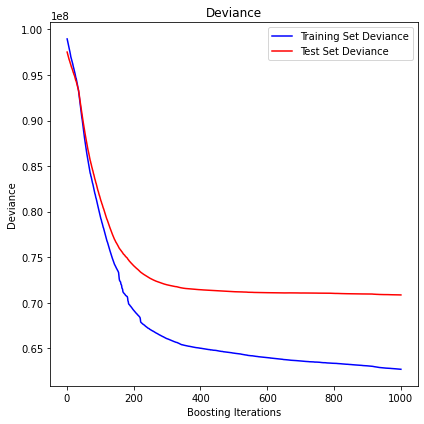

In [275]:
import matplotlib.pyplot as plt
test_score = np.zeros( (params['n_estimators'],),dtype = np.float64)
for i, y_pred in enumerate(gb_reg.staged_predict(x_test)):
    test_score[i] = gb_reg.loss_(y_test, y_pred)
fig = plt.figure(figsize = (6,6))
plt.subplot(1,1,1)
plt.title("Deviance")
plt.plot(np.arange(params['n_estimators']) + 1 ,gb_reg.train_score_,'b-',label = 'Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1 ,test_score,'r-',label = 'Test Set Deviance')
plt.legend(loc = 'upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

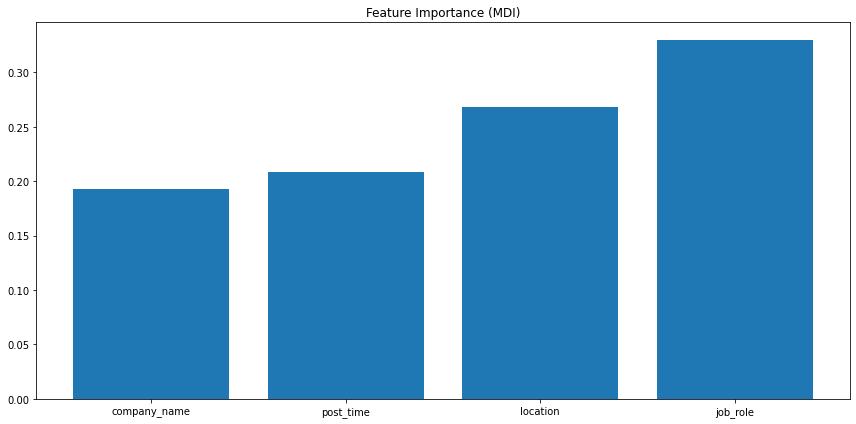

In [283]:
feature_importance = gb_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1,1,1)
plt.bar(pos, feature_importance[sorted_idx], align='center')
plt.xticks(pos, np.array(x_df.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')
fig.tight_layout()
plt.show()